# Catheter placement (Recurrent neural network approach)
We will now consider using recurrent neural networks. More about the rationale behind this approach can be found in the report. The evidence supporting this approach can be found in a paper by Jurkus (2023) on using RNNs for sequential coordinates.

In [73]:
import pandas as pd
import cv2
import os
import ast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.python import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
RS=42#set random seed consistent do not change
height,width,channels=224,224,1#image data structure
num_classes=3
import random
from sklearn.metrics import confusion_matrix,recall_score,precision_score,accuracy_score,classification_report
plt.ioff()
import warnings
warnings.filterwarnings("ignore")#clean notebook outputs

In [2]:
def set_files_on_dataframe(df,tag='StudyInstanceUID'):
  '''
  df: target data frame
  tag: StudyInstanceUID
  '''
  if 'image_file' not in df.columns:
    df['image_file']=''
  for i,row in df.iterrows():
    if '.jpg' not in row[tag]:
      path=row[tag]+'.jpg'
      df._set_value(i,'image_file',path)
    elif '.jpg' in row[tag]:
      path=row[tag]
      df._set_value(i,'image_file',path)
  return df

In [3]:
train=pd.read_csv('train.csv')
train_annots=pd.read_csv('train_annotations.csv')
train=set_files_on_dataframe(train)
train_annots=set_files_on_dataframe(train_annots)

In [4]:
def clean_dataframe(df,cath_type):
    '''
    only runs for train, not train annotations
    '''
    if cath_type == 'CVC' or cath_type == 'ETT':
        dataframe=df[['StudyInstanceUID',cath_type+' - Abnormal',cath_type+' - Normal',cath_type+' - Borderline','image_file']]
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Abnormal'] == 0) & (dataframe[cath_type+' - Normal'] == 0) & (dataframe[cath_type+' - Borderline'] == 0)].index)
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Abnormal'] == 1) & (dataframe[cath_type+' - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Borderline'] == 1) & (dataframe[cath_type+' - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Abnormal'] == 1) & (dataframe[cath_type+' - Borderline'] == 1)].index)
    elif cath_type == 'NGT':
        dataframe=df[['StudyInstanceUID','NGT - Abnormal','NGT - Normal','NGT - Borderline','NGT - Incompletely Imaged','image_file']]
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Abnormal'] == 0) & (dataframe['NGT - Normal'] == 0) & (dataframe['NGT - Borderline'] == 0) & (dataframe['NGT - Incompletely Imaged']==0)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Incompletely Imaged']==1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Abnormal'] == 1) & (dataframe['NGT - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Borderline'] == 1) & (dataframe['NGT - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Abnormal'] == 1) & (dataframe['NGT - Borderline'] == 1)].index)
    return dataframe

In [5]:
ett_annots=train_annots[(train_annots['label']=='ETT - Normal')|(train_annots['label']=='ETT - Abnormal')|(train_annots['label']=='ETT - Borderline')]
ett_annots.reset_index(drop=True,inplace=True)
cvc_annots=train_annots[(train_annots['label']=='CVC - Normal')|(train_annots['label']=='CVC - Abnormal')|(train_annots['label']=='CVC - Borderline')]
cvc_annots.reset_index(drop=True,inplace=True)
ngt_annots=train_annots[(train_annots['label']=='NGT - Normal')|(train_annots['label']=='NGT - Abnormal')|(train_annots['label']=='NGT - Borderline')]
ngt_annots.reset_index(drop=True,inplace=True)

In [6]:
#check quantity of images in a given folder is correct
def count_files_in_directory(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_count += 1
    return file_count


In [7]:
# ChatGPT: how do I get a list of all the absolute paths in a directory
def list_abs_paths_in_dir(directory):
  # Initialize an empty list to store the absolute paths to files
  file_paths = []
  # files=[]
  # Use os.walk() to traverse through the directory and its subdirectories
  for root, dirs, files in os.walk(directory):
      for file in files:
          # Construct the absolute path to the file
          file_path = os.path.abspath(os.path.join(root, file))

          # Append the absolute path to the list
          file_paths.append(file_path)
          # files.append(os.path.basename(file_path))
  return file_paths
def get_filenames_of_abs_paths(absfiles):
  '''
  can only pass after listing absolute paths
  '''
  basefiles=[]
  for i in absfiles:
    basefiles.append(os.path.basename(i))
  return basefiles

In [8]:
paths_ngt=list_abs_paths_in_dir('images_split/NGT/train')+list_abs_paths_in_dir('images_split/NGT/validate')+list_abs_paths_in_dir('images_split/NGT/test')
files_ngt=get_filenames_of_abs_paths(paths_ngt)
ngt_data={'file path':paths_ngt,'image_file':files_ngt}
ngt_abs_df_tv=pd.DataFrame(ngt_data)
ngt_abs_df_tv.sort_values(by=['image_file'],inplace=True)
ngt_annots_tv=ngt_annots[ngt_annots['image_file'].isin(ngt_abs_df_tv['image_file'].tolist())]
ngt_annots_tv.sort_values(by=['image_file'],inplace=True)
ngt_annots_tv.reset_index(drop=True,inplace=True)
ngt_annots_tv=ngt_annots_tv.merge(ngt_abs_df_tv,on='image_file')

In [9]:
paths_cvc=list_abs_paths_in_dir('images_split/CVC/train')+list_abs_paths_in_dir('images_split/CVC/validate')+list_abs_paths_in_dir('images_split/CVC/test')
files_cvc=get_filenames_of_abs_paths(paths_cvc)
cvc_data={'file path':paths_cvc,'image_file':files_cvc}
cvc_abs_df_tv=pd.DataFrame(cvc_data)
cvc_abs_df_tv.sort_values(by=['image_file'],inplace=True)
cvc_annots_tv=cvc_annots[cvc_annots['image_file'].isin(cvc_abs_df_tv['image_file'].tolist())]
cvc_annots_tv.sort_values(by=['image_file'],inplace=True)
cvc_annots_tv.reset_index(drop=True,inplace=True)
cvc_annots_tv=cvc_annots_tv.merge(cvc_abs_df_tv,on='image_file')

In [10]:
paths_ett=list_abs_paths_in_dir('images_split/ETT/train')+list_abs_paths_in_dir('images_split/ETT/validate')+list_abs_paths_in_dir('images_split/ETT/test')
files_ett=get_filenames_of_abs_paths(paths_ett)
ett_data={'file path':paths_ett,'image_file':files_ett}
ett_abs_df_tv=pd.DataFrame(ett_data)
ett_abs_df_tv.sort_values(by=['image_file'],inplace=True)
ett_annots_tv=ett_annots[ett_annots['image_file'].isin(ett_abs_df_tv['image_file'].tolist())]
ett_annots_tv.sort_values(by=['image_file'],inplace=True)
ett_annots_tv.reset_index(drop=True,inplace=True)
ett_annots_tv=ett_annots_tv.merge(ett_abs_df_tv,on='image_file')

In [11]:
def add_feature(df):
  '''
  must reset index
  '''
  df.reset_index(drop=True,inplace=True)
  if 'image' not in df.columns:
    df['image']=''
  for i, row in df.iterrows():
    feature = cv2.imread(row['file path'], cv2.IMREAD_GRAYSCALE)
    df._set_value(i,'image',feature)
  return df

In [12]:
def resize_annots(df):
  '''
  requires df input to have an image column containing the array rep of the image
  '''
  resized_coords = []
  for i in range(len(df)):
    shape = df.loc[i,'image'].shape
    N = shape[1] #y-values
    M = shape[0] #x-values
    data = np.array(ast.literal_eval(df.loc[i,'data']))
    X = data[:, 0]
    Y = data[:, 1]
    x = np.round((X/N)*224,3)
    y = np.round((Y/M)*224,3)
    new_data = str([[a, b] for a, b in zip(x, y)])
    resized_coords.append(new_data)
  df['resized data'] = resized_coords
  return df

In [13]:
#plot resized version
#ref: see EDA
def plot_image_with_annotations(row_ind,df_annot):
  '''
  can only run after resizing annotations
  must have absolute path column
  '''
  row = df_annot.iloc[row_ind]
  image_path = row['file path']
  label = row["label"]
  data = np.array(ast.literal_eval(row["resized data"]))
  plt.figure(figsize=(10, 5))
  image = cv2.imread(image_path)
  image=cv2.resize(image,dsize=(224,224))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.scatter(data[:, 0], data[:, 1])
  plt.suptitle(label, fontsize=15)
  fig=plt.figure()
  plt.show()
  return fig

In [14]:
cvc_processed=add_feature(cvc_annots_tv)
cvc_processed=resize_annots(cvc_processed)
ngt_processed=add_feature(ngt_annots_tv)
ngt_processed=resize_annots(ngt_processed)
ett_processed=add_feature(ett_annots_tv)
ett_processed=resize_annots(ett_processed)

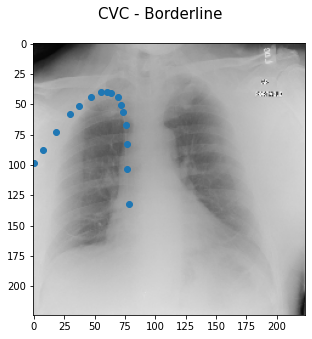

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [15]:
plot_image_with_annotations(10,cvc_processed)

We see that our functions worked! The images are resized and the plot coordinates have similarly resized to appear on the images. For half these images, there are annotated coordinates. We will now use these coordinates exclusively to predict our results

Before proceeding, let's make some assumptions. These methods assume that every patient's chest size is of a certain size (however, this may not matter after all since we are trying to test based on the path of the catheter) and that each placement type is well defined (there has to be a visible pattern regarding the shapes of the plots). We will use recurrent neural networks because of their sequential memory properties and 1-dimensional convolutional neural networks for their ability to deal with projections. Early stopping mechanisms will be put in place to save time and RAM.

First, let's define some auxilary functions that we're going to use throughout this whole analysis. These include plotting loss graphs and confusion matrices as well as one hot encoding functions.

In [16]:
def plot_loss(history,model_type,cath_type):
  fig=plt.figure()
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([min(min(history.history['val_loss']),min(history.history['loss'])),max(max(history.history['loss']),max(history.history['val_loss']))])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.title('Error plot for the '+model_type+' using '+cath_type+' data')  
  plt.legend()
  plt.grid(True)
  return fig

In [17]:
def plt_bin_cnf_mat(model, cath, true_labels, preds):
    conf_matrix = confusion_matrix(true_labels, preds)
    fig, ax = plt.subplots()
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax)

    # Set x-axis label and ticks.
    ax.set_xlabel("Predicted Placement", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['Normal', 'Not Normal'])

    # Set y-axis label and ticks
    ax.set_ylabel("Actual Placement", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['Normal', 'Not Normal'])

    # Set plot title
    ax.set_title("Binary confusion Matrix for the " + model + " on " + cath, fontsize=14, pad=20)
    
    return fig,ax

In [18]:
#plot confusion matrix
def plt_cnf_mat(model, cath, true_labels, preds):
    conf_matrix = confusion_matrix(true_labels, preds)
    fig, ax = plt.subplots()
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax)

    # Set x-axis label and ticks.
    ax.set_xlabel("Predicted Placement", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['Normal', 'Abnormal', 'Borderline'])

    # Set y-axis label and ticks
    ax.set_ylabel("Actual Placement", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['Normal', 'Abnormal', 'Borderline'])

    # Set plot title
    ax.set_title("Confusion Matrix for the " + model + " on " + cath, fontsize=14, pad=20)
    
    return fig,ax

In [19]:
#manual hot encode multi
def encoder(df,cath_type):
  '''
  works only with train annots file
  '''
  outcomes=[]
  for i in range(len(df)):
    if df.loc[i,'label']==cath_type+' - Normal':
      outcomes.append(0)
    if df.loc[i,'label']==cath_type+' - Abnormal':
      outcomes.append(1)
    if df.loc[i,'label']==cath_type+' - Borderline':
      outcomes.append(2)
  df['outcome']=outcomes
  return df

In [20]:
def binary_encoder(df,cath_type):
    outcomes=[]
    for i in range(len(df)):
        if df.loc[i,'label']==cath_type+' - Normal':
            outcomes.append(0)
        else:
            outcomes.append(1)
    df['outcome']=outcomes
    return df

In [21]:
from scipy import stats
def produce_CI(data,confidence_level,metric):
    mean = np.mean(data)
    sem = stats.sem(data)

    # Define the confidence level and degrees of freedom
    degrees_of_freedom = len(data) - 1

    # Calculate the margin of error
    margin_of_error = sem * stats.t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

    # Calculate the confidence interval
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error

    # Print the confidence interval
    print(f"{metric} has CI: {100*confidence_level}% Confidence Interval: ({lower_bound:4f}, {upper_bound:4f})")
    
    

We will do a binary approach first then a multiclass approach next.

In [22]:
cath='CVC'
binary_cvc=binary_encoder(cvc_processed,cath)
cvc_fob=binary_cvc[['resized data','outcome']]
data_x=[]
for i in range(len(cvc_fob)):
  coordinates_list = np.array(ast.literal_eval(cvc_fob['resized data'][i]))
  data_x.append(coordinates_list)
cvc_fob['resized data']=data_x

In [23]:
X=cvc_fob['resized data']
y=cvc_fob['outcome']
from sklearn.preprocessing import OneHotEncoder
# Assuming 'labels' is your original label data
HotEncoder = OneHotEncoder(sparse=False)
y_encoded = HotEncoder.fit_transform(np.array(y).reshape(-1, 1))
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequence_lengths=[]
for i in X:
  sequence_lengths.append(len(i))
max_sequence_length = max(sequence_lengths)
padded_sequences = pad_sequences(X, maxlen=max_sequence_length, padding='post', dtype='float32')
X_train,X_test,y_train,y_test=train_test_split(padded_sequences,y_encoded,random_state=RS,test_size=0.2)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,random_state=RS,test_size=0.5)

In [24]:
batch_size = len(padded_sequences)  # Use the length of your data as batch size
epochs=50
num_classes=2
reducelr_cb = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)
early_stopping_cb = EarlyStopping(patience=5,
                                  restore_best_weights=True)
#to get a confidence interval for the different metrics, we increase the number of "runs"
#to approximate accuracy and recall distributions to a normal distribution
sample_size=30
cvc_training_accuracies_bin=[]
cvc_val_accuracies_bin=[]
cvc_plotlosses_bin=[]
cvc_testing_accuracies_bin=[]
cvc_testing_recall=[]
cvc_testing_precision=[]
cvc_matrices_bin=[]
for i in range(sample_size):
    #randomise weights
    model = Sequential()

    # Input layer (specify input_shape based on your data)
    model.add(LSTM(64, input_shape=(padded_sequences.shape[1],2)))

    # Additional layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))  # Dropout layer for regularization

    model.add(Dense(64, activation='relu'))

    # Output layer (adjust units for the number of classes)
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
    filepath="RNN models/"+cath+"/binary/best_weights_"+cath+'_'+str(i)+"_bin.h5",
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,      # Save only the best weights
    mode='max',               # Save when validation accuracy is at its maximum
    verbose=0
    )
    #ChatGPT: how do I do Monte Carlo simulation when training and testing neural networks
    historyRNN = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_val, y_val), verbose=0,
                    callbacks=[reducelr_cb,early_stopping_cb,checkpoint]);#get results
    best_model = load_model("RNN models/"+cath+"/binary/best_weights_"+cath+'_'+str(i)+"_bin.h5")
    cvc_plotlosses_bin.append(plot_loss(historyRNN,'RNN',cath))
    logits=best_model.predict(X_test)
    preds=tf.argmax(tf.nn.softmax(logits), 1)
    true_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices
    recall_binary=recall_score(true_labels,preds)
    precision_binary=precision_score(true_labels,preds)
    train_accuracy = best_model.evaluate(X_train, y_train)[1]
    val_accuracy = best_model.evaluate(X_val, y_val)[1]
    cvc_training_accuracies_bin.append(train_accuracy)
    cvc_val_accuracies_bin.append(val_accuracy)
    cvc_testing_recall.append(recall_binary)
    cvc_testing_precision.append(precision_binary)
    cvc_testing_accuracies_bin.append(np.round(accuracy_score(true_labels,preds),3))
    cvc_matrices_bin.append(plt_bin_cnf_mat('RNN', cath, true_labels, preds))

10/10 [==============================] - 0s 5ms/step - loss: 0.6656 - accuracy: 0.6271


In [25]:
produce_CI(data=cvc_training_accuracies_bin,confidence_level=0.95,metric='Training accuracy')
produce_CI(data=cvc_val_accuracies_bin,confidence_level=0.95,metric='Validation accuracy')
produce_CI(data=cvc_testing_accuracies_bin,confidence_level=0.95,metric='Testing accuracy')
produce_CI(data=cvc_testing_recall,confidence_level=0.95,metric='Recall for normal')
produce_CI(data=cvc_testing_precision,confidence_level=0.95,metric='Precision for normal')

Training accuracy has CI: 95.0% Confidence Interval: (0.606809, 0.615753)
Validation accuracy has CI: 95.0% Confidence Interval: (0.628178, 0.636508)
Testing accuracy has CI: 95.0% Confidence Interval: (0.595110, 0.606290)
Recall for normal has CI: 95.0% Confidence Interval: (0.900058, 0.982360)
Recall for normal has CI: 95.0% Confidence Interval: (0.900058, 0.982360)
Precision for normal has CI: 95.0% Confidence Interval: (0.602328, 0.619424)


CVC training accuracy is 0.6264463067054749
CVC validation accuracy is 0.6534653306007385
CVC testing accuracy is 0.584
CVC testing recall is 0.7307692307692307
CVC testing precision is 0.6333333333333333


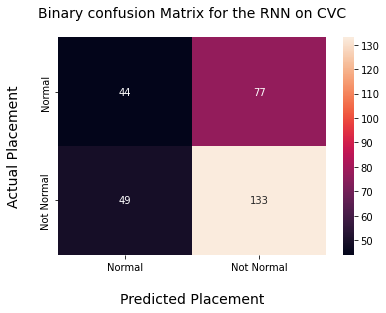

In [67]:
idx=12
fig,axes=cvc_matrices_bin[idx]
print(f"CVC training accuracy is {cvc_training_accuracies_bin[idx]}")
print(f"CVC validation accuracy is {cvc_val_accuracies_bin[idx]}")
print(f"CVC testing accuracy is {cvc_testing_accuracies_bin[idx]}")
print(f"CVC testing recall is {cvc_testing_recall[idx]}")
print(f"CVC testing precision is {cvc_testing_precision[idx]}")
fig

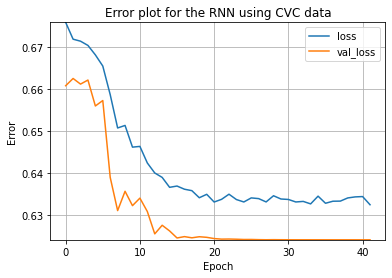

In [68]:
fig=cvc_plotlosses_bin[idx]
fig

Next, let's repeat for the NGT catheter.

In [28]:
cath='NGT'
binary_ngt=binary_encoder(ngt_processed,cath)
ngt_fob=binary_ngt[['resized data','outcome']]
data_x=[]
for i in range(len(ngt_fob)):
  coordinates_list = np.array(ast.literal_eval(ngt_fob['resized data'][i]))
  data_x.append(coordinates_list)
ngt_fob['resized data']=data_x

In [29]:
X=ngt_fob['resized data']
y=ngt_fob['outcome']
from sklearn.preprocessing import OneHotEncoder
# Assuming 'labels' is your original label data
HotEncoder = OneHotEncoder(sparse=False)
y_encoded = HotEncoder.fit_transform(np.array(y).reshape(-1, 1))
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequence_lengths=[]
for i in X:
  sequence_lengths.append(len(i))
max_sequence_length = max(sequence_lengths)
padded_sequences = pad_sequences(X, maxlen=max_sequence_length, padding='post', dtype='float32')
X_train,X_test,y_train,y_test=train_test_split(padded_sequences,y_encoded,random_state=RS,test_size=0.2)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,random_state=RS,test_size=0.5)

In [30]:
batch_size = len(padded_sequences)  # Use the length of your data as batch size
epochs=50
num_classes=2
reducelr_cb = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)
early_stopping_cb = EarlyStopping(patience=5,
                                  restore_best_weights=True)
#to get a confidence interval for the different metrics, we increase the number of "runs"
#to approximate accuracy and recall distributions to a normal distribution
sample_size=30
ngt_training_accuracies_bin=[]
ngt_val_accuracies_bin=[]
ngt_plotlosses_bin=[]
ngt_testing_accuracies_bin=[]
ngt_testing_recall=[]
ngt_matrices_bin=[]
ngt_testing_precision=[]
for i in range(sample_size):
    #randomise weights
    model = Sequential()

    # Input layer (specify input_shape based on your data)
    model.add(LSTM(64, input_shape=(padded_sequences.shape[1],2)))

    # Additional layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))  # Dropout layer for regularization

    model.add(Dense(64, activation='relu'))

    # Output layer (adjust units for the number of classes)
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
    filepath="RNN models/"+cath+"/binary/best_weights_"+cath+'_'+str(i)+"_bin.h5",
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,      # Save only the best weights
    mode='max',               # Save when validation accuracy is at its maximum
    verbose=0
    )
    #ChatGPT: how do I do Monte Carlo simulation when training and testing neural networks
    historyRNN = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_val, y_val), verbose=0,
                    callbacks=[reducelr_cb,early_stopping_cb,checkpoint]);#get results
    best_model = load_model("RNN models/"+cath+"/binary/best_weights_"+cath+'_'+str(i)+"_bin.h5")
    ngt_plotlosses_bin.append(plot_loss(historyRNN,'RNN',cath))
    logits=best_model.predict(X_test)
    preds=tf.argmax(tf.nn.softmax(logits), 1)
    true_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices
    recall_binary=recall_score(true_labels,preds)
    precision_binary=precision_score(true_labels,preds)
    train_accuracy = best_model.evaluate(X_train, y_train)[1]
    val_accuracy = best_model.evaluate(X_val, y_val)[1]
    ngt_training_accuracies_bin.append(train_accuracy)
    ngt_val_accuracies_bin.append(val_accuracy)
    ngt_testing_recall.append(recall_binary)
    ngt_testing_precision.append(precision_binary)
    ngt_testing_accuracies_bin.append(np.round(accuracy_score(true_labels,preds),3))
    ngt_matrices_bin.append(plt_bin_cnf_mat('RNN', cath, true_labels, preds))

3/3 [==============================] - 0s 3ms/step - loss: 0.4810 - accuracy: 0.7882


In [31]:
produce_CI(data=ngt_training_accuracies_bin,confidence_level=0.95,metric='Training accuracy')
produce_CI(data=ngt_val_accuracies_bin,confidence_level=0.95,metric='Validation accuracy')
produce_CI(data=ngt_testing_accuracies_bin,confidence_level=0.95,metric='Testing accuracy')
produce_CI(data=ngt_testing_recall,confidence_level=0.95,metric='Recall for normal')
produce_CI(data=ngt_testing_precision,confidence_level=0.95,metric='Precision for normal')

Training accuracy has CI: 95.0% Confidence Interval: (0.758279, 0.780055)
Validation accuracy has CI: 95.0% Confidence Interval: (0.798033, 0.807457)
Testing accuracy has CI: 95.0% Confidence Interval: (0.729966, 0.753168)
Recall for normal has CI: 95.0% Confidence Interval: (0.605567, 0.698137)
Precision for normal has CI: 95.0% Confidence Interval: (0.702450, 0.745379)


NGT training accuracy is 0.720588207244873
NGT validation accuracy is 0.800000011920929
NGT testing accuracy is 0.694
NGT testing recall is 0.7777777777777778
NGT testing precision is 0.6086956521739131


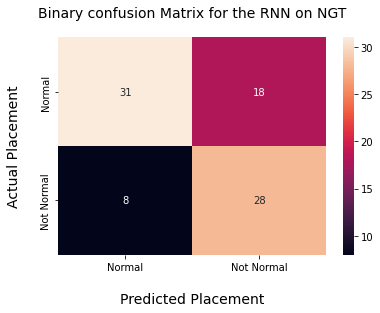

In [69]:
idx=10
fig,axes=ngt_matrices_bin[idx]
print(f"NGT training accuracy is {ngt_training_accuracies_bin[idx]}")
print(f"NGT validation accuracy is {ngt_val_accuracies_bin[idx]}")
print(f"NGT testing accuracy is {ngt_testing_accuracies_bin[idx]}")
print(f"NGT testing recall is {ngt_testing_recall[idx]}")
print(f"NGT testing precision is {ngt_testing_precision[idx]}")
fig

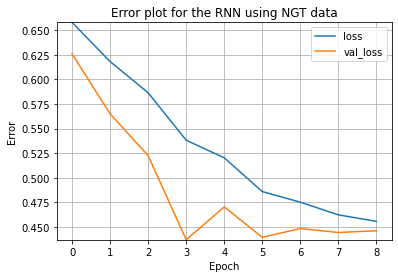

In [70]:
fig=ngt_plotlosses_bin[idx]
fig

Lastly, let's do this same process for the ETT catheter

In [34]:
cath='ETT'
binary_ett=binary_encoder(ett_processed,cath)
ett_fob=binary_ett[['resized data','outcome']]
data_x=[]
for i in range(len(ett_fob)):
  coordinates_list = np.array(ast.literal_eval(ett_fob['resized data'][i]))
  data_x.append(coordinates_list)
ett_fob['resized data']=data_x

In [35]:
X=ett_fob['resized data']
y=ett_fob['outcome']
from sklearn.preprocessing import OneHotEncoder
# Assuming 'labels' is your original label data
HotEncoder = OneHotEncoder(sparse=False)
y_encoded = HotEncoder.fit_transform(np.array(y).reshape(-1, 1))
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequence_lengths=[]
for i in X:
  sequence_lengths.append(len(i))
max_sequence_length = max(sequence_lengths)
padded_sequences = pad_sequences(X, maxlen=max_sequence_length, padding='post', dtype='float32')
X_train,X_test,y_train,y_test=train_test_split(padded_sequences,y_encoded,random_state=RS,test_size=0.2)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,random_state=RS,test_size=0.5)

In [36]:
batch_size = len(padded_sequences)  # Use the length of your data as batch size
epochs=50
num_classes=2
reducelr_cb = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)
early_stopping_cb = EarlyStopping(patience=5,
                                  restore_best_weights=True)
#to get a confidence interval for the different metrics, we increase the number of "runs"
#to approximate accuracy and recall distributions to a normal distribution
sample_size=30
ett_training_accuracies_bin=[]
ett_val_accuracies_bin=[]
ett_plotlosses_bin=[]
ett_testing_accuracies_bin=[]
ett_testing_recall=[]
ett_testing_precision=[]
ett_matrices_bin=[]
for i in range(sample_size):
    #randomise weights
    model = Sequential()

    # Input layer (specify input_shape based on your data)
    model.add(LSTM(64, input_shape=(padded_sequences.shape[1],2)))

    # Additional layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))  # Dropout layer for regularization

    model.add(Dense(64, activation='relu'))

    # Output layer (adjust units for the number of classes)
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
    filepath="RNN models/"+cath+"/binary/best_weights_"+cath+'_'+str(i)+"_bin.h5",
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,      # Save only the best weights
    mode='max',               # Save when validation accuracy is at its maximum
    verbose=0
    )
    #ChatGPT: how do I do Monte Carlo simulation when training and testing neural networks
    historyRNN = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_val, y_val), verbose=0,
                    callbacks=[reducelr_cb,early_stopping_cb,checkpoint]);#get results
    best_model = load_model("RNN models/"+cath+"/binary/best_weights_"+cath+'_'+str(i)+"_bin.h5")
    ett_plotlosses_bin.append(plot_loss(historyRNN,'RNN',cath))
    logits=best_model.predict(X_test)
    preds=tf.argmax(tf.nn.softmax(logits), 1)
    true_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices
    recall_binary=recall_score(true_labels,preds)
    precision_binary=precision_score(true_labels,preds)
    train_accuracy = best_model.evaluate(X_train, y_train)[1]
    val_accuracy = best_model.evaluate(X_val, y_val)[1]
    ett_training_accuracies_bin.append(train_accuracy)
    ett_val_accuracies_bin.append(val_accuracy)
    ett_testing_recall.append(recall_binary)
    ett_testing_precision.append(precision_binary)
    ett_testing_accuracies_bin.append(np.round(accuracy_score(true_labels,preds),3))
    ett_matrices_bin.append(plt_bin_cnf_mat('RNN', cath, true_labels, preds))

4/4 [==============================] - 0s 2ms/step - loss: 0.5103 - accuracy: 0.7540


In [37]:
produce_CI(data=ett_training_accuracies_bin,confidence_level=0.95,metric='Training accuracy')
produce_CI(data=ett_val_accuracies_bin,confidence_level=0.95,metric='Validation accuracy')
produce_CI(data=ett_testing_accuracies_bin,confidence_level=0.95,metric='Testing accuracy')
produce_CI(data=ett_testing_recall,confidence_level=0.95,metric='Recall for normal')
produce_CI(data=ett_testing_precision,confidence_level=0.95,metric='Precision for normal')

Training accuracy has CI: 95.0% Confidence Interval: (0.700181, 0.709958)
Validation accuracy has CI: 95.0% Confidence Interval: (0.747329, 0.755316)
Testing accuracy has CI: 95.0% Confidence Interval: (0.677541, 0.706059)
Recall for normal has CI: 95.0% Confidence Interval: (0.495239, 0.594957)
Precision for normal has CI: 95.0% Confidence Interval: (0.612001, 0.668485)


ETT training accuracy is 0.7077534794807434
ETT validation accuracy is 0.7460317611694336
ETT testing accuracy is 0.667
ETT testing recall is 0.3333333333333333
ETT testing precision is 0.68


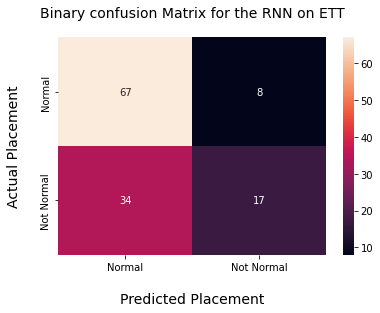

In [88]:
idx=5
fig,axes=ett_matrices_bin[idx]
print(f"ETT training accuracy is {ett_training_accuracies_bin[idx]}")
print(f"ETT validation accuracy is {ett_val_accuracies_bin[idx]}")
print(f"ETT testing accuracy is {ett_testing_accuracies_bin[idx]}")
print(f"ETT testing recall is {ett_testing_recall[idx]}")
print(f"ETT testing precision is {ett_testing_precision[idx]}")
fig

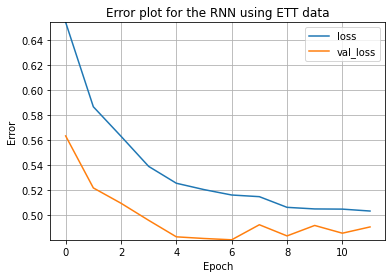

In [72]:
fig=ett_plotlosses_bin[idx]
fig

Let's start the training and testing processes now for the multiclass approach

In [40]:
cath='CVC'
multi_trial=encoder(cvc_processed,cath)
fo=multi_trial[['resized data','outcome']]
data_x=[]
for i in range(len(fo)):
  coordinates_list = np.array(ast.literal_eval(fo['resized data'][i]))
  data_x.append(coordinates_list)
fo['resized data']=data_x

In [41]:
X=fo['resized data']
y=fo['outcome']
from sklearn.preprocessing import OneHotEncoder
# Assuming 'labels' is your original label data
HotEncoder = OneHotEncoder(sparse=False)
y_encoded = HotEncoder.fit_transform(np.array(y).reshape(-1, 1))
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequence_lengths=[]
for i in X:
  sequence_lengths.append(len(i))
max_sequence_length = max(sequence_lengths)
padded_sequences = pad_sequences(X, maxlen=max_sequence_length, padding='post', dtype='float32')
X_train,X_test,y_train,y_test=train_test_split(padded_sequences,y_encoded,random_state=RS,test_size=0.2)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,random_state=RS,test_size=0.5)

In [46]:
# Reshape to fit RNN input shape
batch_size = len(padded_sequences)  # Use the length of your data as batch size
epochs=50
num_classes=3
reducelr_cb = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)
early_stopping_cb = EarlyStopping(patience=5,
                                  restore_best_weights=True)
#to get a confidence interval for the different metrics, we increase the number of "runs"
#to approximate accuracy and recall distributions to a normal distribution
sample_size=30
cvc_training_accuracies=[]
cvc_val_accuracies=[]
cvc_plotlosses=[]
cvc_testing_accuracies=[]
cvc_testing_recall_normal=[]
cvc_testing_recall_abnormal=[]
cvc_testing_recall_borderline=[]
cvc_testing_precision_normal=[]
cvc_testing_precision_abnormal=[]
cvc_testing_precision_borderline=[]
cvc_matrices=[]
for i in range(sample_size):
    #randomise weights
    model = Sequential()

    # Input layer (specify input_shape based on your data)
    model.add(LSTM(64, input_shape=(padded_sequences.shape[1],2)))

    # Additional layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))  # Dropout layer for regularization

    model.add(Dense(64, activation='relu'))

    # Output layer (adjust units for the number of classes)
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
    filepath="RNN models/"+cath+"/multi/best_weights_"+cath+'_'+str(i)+".h5",
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,      # Save only the best weights
    mode='max',               # Save when validation accuracy is at its maximum
    verbose=0
    )
    #ChatGPT: how do I do Monte Carlo simulation when training and testing neural networks
    historyRNN = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_val, y_val), verbose=0,
                    callbacks=[reducelr_cb,early_stopping_cb,checkpoint]);#get results
    best_model = load_model("RNN models/"+cath+"/multi/best_weights_"+cath+'_'+str(i)+".h5")
    cvc_plotlosses.append(plot_loss(historyRNN,'RNN',cath))
    logits=best_model.predict(X_test)
    preds=tf.argmax(tf.nn.softmax(logits), 1)
    true_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices
    recall_scores=recall_score(true_labels,preds,average=None)
    precision_scores=precision_score(true_labels,preds,average=None)
    train_accuracy = best_model.evaluate(X_train, y_train)[1]
    val_accuracy = best_model.evaluate(X_val, y_val)[1]
    cvc_training_accuracies.append(train_accuracy)
    cvc_val_accuracies.append(val_accuracy)
    cvc_testing_recall_normal.append(recall_scores[0])
    cvc_testing_recall_abnormal.append(recall_scores[1])
    cvc_testing_recall_borderline.append(recall_scores[2])
    cvc_testing_precision_normal.append(precision_scores[0])
    cvc_testing_precision_abnormal.append(precision_scores[1])
    cvc_testing_precision_borderline.append(precision_scores[2])
    cvc_testing_accuracies.append(np.round(accuracy_score(true_labels,preds),3))
    cvc_matrices.append(plt_cnf_mat('RNN', cath, true_labels, preds))

10/10 [==============================] - 0s 5ms/step - loss: 1.0925 - accuracy: 0.3729


In [47]:
#generate 95% CIs for all relevant metrics
produce_CI(data=cvc_training_accuracies,confidence_level=0.95,metric='Training accuracy')
produce_CI(data=cvc_val_accuracies,confidence_level=0.95,metric='Validation accuracy')
produce_CI(data=cvc_testing_accuracies,confidence_level=0.95,metric='Testing accuracy')
produce_CI(data=cvc_testing_recall_normal,confidence_level=0.95,metric='Recall for normal')
produce_CI(data=cvc_testing_recall_abnormal,confidence_level=0.95,metric='Recall for abnormal')
produce_CI(data=cvc_testing_recall_borderline,confidence_level=0.95,metric='Recall for borderline')
produce_CI(data=cvc_testing_precision_normal,confidence_level=0.95,metric='Precision for normal')
produce_CI(data=cvc_testing_precision_abnormal,confidence_level=0.95,metric='Precision for abnormal')
produce_CI(data=cvc_testing_precision_borderline,confidence_level=0.95,metric='Precision for borderline')

Training accuracy has CI: 95.0% Confidence Interval: (0.407474, 0.430984)
Validation accuracy has CI: 95.0% Confidence Interval: (0.394492, 0.426190)
Testing accuracy has CI: 95.0% Confidence Interval: (0.409972, 0.432828)
Recall for normal has CI: 95.0% Confidence Interval: (0.842202, 0.940167)
Recall for abnormal has CI: 95.0% Confidence Interval: (0.106792, 0.313600)
Recall for borderline has CI: 95.0% Confidence Interval: (0.010509, 0.030728)
Precision for normal has CI: 95.0% Confidence Interval: (0.416824, 0.449573)
Precision for abnormal has CI: 95.0% Confidence Interval: (0.128946, 0.268362)
Precision for borderline has CI: 95.0% Confidence Interval: (0.235646, 0.509619)


CVC training accuracy is 0.3987603187561035
CVC validation accuracy is 0.3861386179924011
CVC testing accuracy is 0.406
CVC testing recall for normal is 0.9834710743801653
CVC testing recall for abnormal is 0.011764705882352941
CVC testing recall for borderline is 0.030927835051546393
CVC testing precision for normal is 0.40476190476190477
CVC testing precision for abnormal is 0.2
CVC testing precision for borderline is 0.75


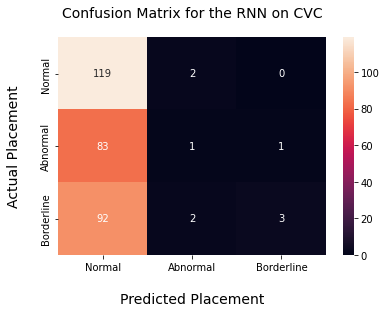

In [78]:
idx=11
fig,axes=cvc_matrices[idx]
print(f"CVC training accuracy is {cvc_training_accuracies[idx]}")
print(f"CVC validation accuracy is {cvc_val_accuracies[idx]}")
print(f"CVC testing accuracy is {cvc_testing_accuracies[idx]}")
print(f"CVC testing recall for normal is {cvc_testing_recall_normal[idx]}")
print(f"CVC testing recall for abnormal is {cvc_testing_recall_abnormal[idx]}")
print(f"CVC testing recall for borderline is {cvc_testing_recall_borderline[idx]}")
print(f"CVC testing precision for normal is {cvc_testing_precision_normal[idx]}")
print(f"CVC testing precision for abnormal is {cvc_testing_precision_abnormal[idx]}")
print(f"CVC testing precision for borderline is {cvc_testing_precision_borderline[idx]}")
fig

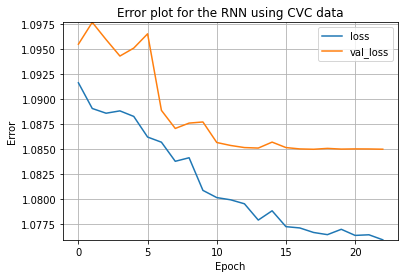

In [77]:
fig=cvc_plotlosses[idx]
fig

Let's repeat this method for the other catheters and see how we go.

In [50]:
#check to see if the procedure works
cath='NGT'
multi_trial=encoder(ngt_processed,cath)
fo=multi_trial[['resized data','outcome']]
data_x=[]
for i in range(len(fo)):
  coordinates_list = np.array(ast.literal_eval(fo['resized data'][i]))
  data_x.append(coordinates_list)
fo['resized data']=data_x

In [51]:
X=fo['resized data']
y=fo['outcome']
# Assuming 'labels' is your original label data
HotEncoder = OneHotEncoder(sparse=False)
y_encoded = HotEncoder.fit_transform(np.array(y).reshape(-1, 1))
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequence_lengths=[]
for i in X:
  sequence_lengths.append(len(i))
max_sequence_length = max(sequence_lengths)
padded_sequences = pad_sequences(X, maxlen=max_sequence_length, padding='post', dtype='float32')
X_train,X_test,y_train,y_test=train_test_split(padded_sequences,y_encoded,random_state=RS,test_size=0.2)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,random_state=RS,test_size=0.5)

In [52]:
# Reshape to fit RNN input shape
ngt_training_accuracies=[]
ngt_val_accuracies=[]
ngt_plotlosses=[]
ngt_testing_accuracies=[]
ngt_testing_recall_normal=[]
ngt_testing_recall_abnormal=[]
ngt_testing_recall_borderline=[]
ngt_testing_precision_normal=[]
ngt_testing_precision_abnormal=[]
ngt_testing_precision_borderline=[]
ngt_matrices=[]
for i in range(sample_size):
    #randomise weights
    model = Sequential()

    # Input layer (specify input_shape based on your data)
    model.add(LSTM(64, input_shape=(padded_sequences.shape[1],2)))

    # Additional layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))  # Dropout layer for regularization

    model.add(Dense(64, activation='relu'))

    # Output layer (adjust units for the number of classes)
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
    filepath="RNN models/"+cath+"/multi/best_weights_"+cath+'_'+str(i)+".h5",
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,      # Save only the best weights
    mode='max',               # Save when validation accuracy is at its maximum
    verbose=0
    )
    #ChatGPT: how do I do Monte Carlo simulation when training and testing neural networks
    historyRNN = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_val, y_val), verbose=0,
                    callbacks=[reducelr_cb,early_stopping_cb,checkpoint]);#get results
    best_model = load_model("RNN models/"+cath+"/multi/best_weights_"+cath+'_'+str(i)+".h5")
    ngt_plotlosses.append(plot_loss(historyRNN,'RNN',cath))
    logits=best_model.predict(X_test)
    preds=tf.argmax(tf.nn.softmax(logits), 1)
    true_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices
    recall_scores=recall_score(true_labels,preds,average=None)
    precision_scores=precision_score(true_labels,preds,average=None)
    train_accuracy = best_model.evaluate(X_train, y_train)[1]
    val_accuracy = best_model.evaluate(X_val, y_val)[1]
    ngt_training_accuracies.append(train_accuracy)
    ngt_val_accuracies.append(val_accuracy)
    ngt_testing_recall_normal.append(recall_scores[0])
    ngt_testing_recall_abnormal.append(recall_scores[1])
    ngt_testing_recall_borderline.append(recall_scores[2])
    ngt_testing_precision_normal.append(precision_scores[0])
    ngt_testing_precision_abnormal.append(precision_scores[1])
    ngt_testing_precision_borderline.append(precision_scores[2])
    ngt_testing_accuracies.append(np.round(accuracy_score(true_labels,preds),3))
    ngt_matrices.append(plt_cnf_mat('RNN', cath, true_labels, preds))

3/3 [==============================] - 0s 3ms/step - loss: 0.5740 - accuracy: 0.7765


In [53]:
produce_CI(data=ngt_training_accuracies,confidence_level=0.95,metric='Training accuracy')
produce_CI(data=ngt_val_accuracies,confidence_level=0.95,metric='Validation accuracy')
produce_CI(data=ngt_testing_accuracies,confidence_level=0.95,metric='Testing accuracy')
produce_CI(data=ngt_testing_recall_normal,confidence_level=0.95,metric='Recall for normal')
produce_CI(data=ngt_testing_recall_abnormal,confidence_level=0.95,metric='Recall for abnormal')
produce_CI(data=ngt_testing_recall_borderline,confidence_level=0.95,metric='Recall for borderline')
produce_CI(data=ngt_testing_precision_normal,confidence_level=0.95,metric='Precision for normal')
produce_CI(data=ngt_testing_precision_abnormal,confidence_level=0.95,metric='Precision for abnormal')
produce_CI(data=ngt_testing_precision_borderline,confidence_level=0.95,metric='Precision for borderline')

Training accuracy has CI: 95.0% Confidence Interval: (0.729372, 0.748864)
Validation accuracy has CI: 95.0% Confidence Interval: (0.761497, 0.771837)
Testing accuracy has CI: 95.0% Confidence Interval: (0.673677, 0.690256)
Recall for normal has CI: 95.0% Confidence Interval: (0.874043, 0.915073)
Recall for abnormal has CI: 95.0% Confidence Interval: (0.620923, 0.651804)
Recall for borderline has CI: 95.0% Confidence Interval: (0.242413, 0.328254)
Precision for normal has CI: 95.0% Confidence Interval: (0.748352, 0.772532)
Precision for abnormal has CI: 95.0% Confidence Interval: (0.494302, 0.546343)
Precision for borderline has CI: 95.0% Confidence Interval: (0.487614, 0.607115)


NGT training accuracy is 0.7308823466300964
NGT validation accuracy is 0.7764706015586853
NGT testing accuracy is 0.682
NGT testing recall for normal is 0.9387755102040817
NGT testing recall for abnormal is 0.5454545454545454
NGT testing recall for borderline is 0.24
NGT testing precision for normal is 0.7301587301587301
NGT testing precision for abnormal is 0.5
NGT testing precision for borderline is 0.6


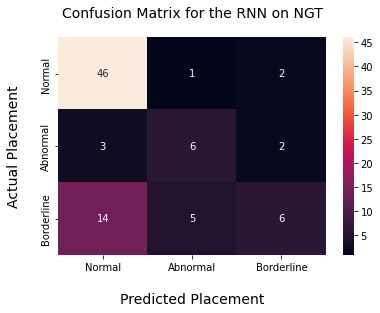

In [79]:
idx=11
fig,axes=ngt_matrices[idx]
print(f"NGT training accuracy is {ngt_training_accuracies[idx]}")
print(f"NGT validation accuracy is {ngt_val_accuracies[idx]}")
print(f"NGT testing accuracy is {ngt_testing_accuracies[idx]}")
print(f"NGT testing recall for normal is {ngt_testing_recall_normal[idx]}")
print(f"NGT testing recall for abnormal is {ngt_testing_recall_abnormal[idx]}")
print(f"NGT testing recall for borderline is {ngt_testing_recall_borderline[idx]}")
print(f"NGT testing precision for normal is {ngt_testing_precision_normal[idx]}")
print(f"NGT testing precision for abnormal is {ngt_testing_precision_abnormal[idx]}")
print(f"NGT testing precision for borderline is {ngt_testing_precision_borderline[idx]}")
fig

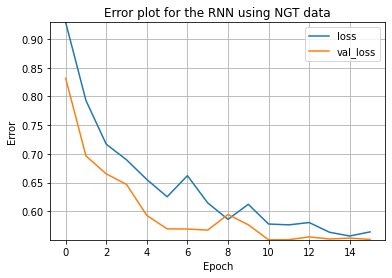

In [80]:
fig=ngt_plotlosses[idx]
fig

In [56]:
#check to see if the procedure works
cath='ETT'
multi_trial=encoder(ett_processed,cath)
fo=multi_trial[['resized data','outcome']]
data_x=[]
for i in range(len(fo)):
  coordinates_list = np.array(ast.literal_eval(fo['resized data'][i]))
  data_x.append(coordinates_list)
fo['resized data']=data_x

In [57]:
X=fo['resized data']
y=fo['outcome']
# Assuming 'labels' is your original label data
HotEncoder = OneHotEncoder(sparse=False)
y_encoded = HotEncoder.fit_transform(np.array(y).reshape(-1, 1))
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequence_lengths=[]
for i in X:
  sequence_lengths.append(len(i))
max_sequence_length = max(sequence_lengths)
padded_sequences = pad_sequences(X, maxlen=max_sequence_length, padding='post', dtype='float32')
X_train,X_test,y_train,y_test=train_test_split(padded_sequences,y_encoded,random_state=RS,test_size=0.2)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,random_state=RS,test_size=0.5)

In [58]:
# Reshape to fit RNN input shape
ett_training_accuracies=[]
ett_val_accuracies=[]
ett_plotlosses=[]
ett_testing_accuracies=[]
ett_testing_recall_normal=[]
ett_testing_recall_abnormal=[]
ett_testing_recall_borderline=[]
ett_testing_precision_normal=[]
ett_testing_precision_abnormal=[]
ett_testing_precision_borderline=[]
ett_matrices=[]
for i in range(sample_size):
    #randomise weights
    model = Sequential()

    # Input layer (specify input_shape based on your data)
    model.add(LSTM(64, input_shape=(padded_sequences.shape[1],2)))

    # Additional layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))  # Dropout layer for regularization

    model.add(Dense(64, activation='relu'))

    # Output layer (adjust units for the number of classes)
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
    filepath="RNN models/"+cath+"/multi/best_weights_"+cath+'_'+str(i)+".h5",
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,      # Save only the best weights
    mode='max',               # Save when validation accuracy is at its maximum
    verbose=0
    )
    #ChatGPT: how do I do Monte Carlo simulation when training and testing neural networks
    historyRNN = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_val, y_val), verbose=0,
                    callbacks=[reducelr_cb,early_stopping_cb,checkpoint]);#get results
    best_model = load_model("RNN models/"+cath+"/multi/best_weights_"+cath+'_'+str(i)+".h5")
    ett_plotlosses.append(plot_loss(historyRNN,'RNN',cath))
    logits=best_model.predict(X_test)
    preds=tf.argmax(tf.nn.softmax(logits), 1)
    true_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices
    recall_scores=recall_score(true_labels,preds,average=None)
    precision_scores=precision_score(true_labels,preds,average=None)
    train_accuracy = best_model.evaluate(X_train, y_train)[1]
    val_accuracy = best_model.evaluate(X_val, y_val)[1]
    ett_training_accuracies.append(train_accuracy)
    ett_val_accuracies.append(val_accuracy)
    ett_testing_recall_normal.append(recall_scores[0])
    ett_testing_recall_abnormal.append(recall_scores[1])
    ett_testing_recall_borderline.append(recall_scores[2])
    ett_testing_precision_normal.append(precision_scores[0])
    ett_testing_precision_abnormal.append(precision_scores[1])
    ett_testing_precision_borderline.append(precision_scores[2])
    ett_testing_accuracies.append(np.round(accuracy_score(true_labels,preds),3))
    ett_matrices.append(plt_cnf_mat('RNN', cath, true_labels, preds))

4/4 [==============================] - 0s 2ms/step - loss: 0.6463 - accuracy: 0.7381


In [60]:
produce_CI(data=ett_training_accuracies,confidence_level=0.95,metric='Training accuracy')
produce_CI(data=ett_val_accuracies,confidence_level=0.95,metric='Validation accuracy')
produce_CI(data=ett_testing_accuracies,confidence_level=0.95,metric='Testing accuracy')
produce_CI(data=ett_testing_recall_normal,confidence_level=0.95,metric='Recall for normal')
produce_CI(data=ett_testing_recall_abnormal,confidence_level=0.95,metric='Recall for abnormal')
produce_CI(data=ett_testing_recall_borderline,confidence_level=0.95,metric='Recall for borderline')
produce_CI(data=ett_testing_precision_normal,confidence_level=0.95,metric='Precision for normal')
produce_CI(data=ett_testing_precision_abnormal,confidence_level=0.95,metric='Precision for abnormal')
produce_CI(data=ett_testing_precision_borderline,confidence_level=0.95,metric='Precision for borderline')

Training accuracy has CI: 95.0% Confidence Interval: (0.680855, 0.699132)
Validation accuracy has CI: 95.0% Confidence Interval: (0.731180, 0.739190)
Testing accuracy has CI: 95.0% Confidence Interval: (0.667033, 0.700967)
Recall for normal has CI: 95.0% Confidence Interval: (0.847115, 0.903107)
Recall for abnormal has CI: 95.0% Confidence Interval: (0.000000, 0.000000)
Recall for borderline has CI: 95.0% Confidence Interval: (0.364768, 0.529435)
Precision for normal has CI: 95.0% Confidence Interval: (0.687676, 0.732348)
Precision for abnormal has CI: 95.0% Confidence Interval: (0.000000, 0.000000)
Precision for borderline has CI: 95.0% Confidence Interval: (0.508304, 0.668471)


ETT training accuracy is 0.7077534794807434
ETT validation accuracy is 0.7301587462425232
ETT testing accuracy is 0.69
ETT testing recall for normal is 0.8933333333333333
ETT testing recall for abnormal is 0.0
ETT testing recall for borderline is 0.43478260869565216
ETT testing precision for normal is 0.7052631578947368
ETT testing precision for abnormal is 0.0
ETT testing precision for borderline is 0.6451612903225806


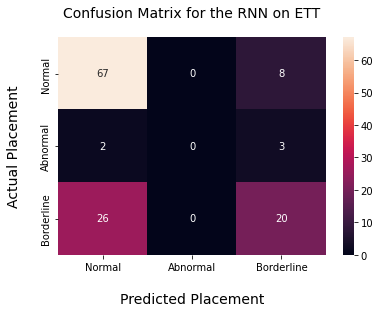

In [86]:
idx=15
fig,axes=ett_matrices[idx]
print(f"ETT training accuracy is {ett_training_accuracies[idx]}")
print(f"ETT validation accuracy is {ett_val_accuracies[idx]}")
print(f"ETT testing accuracy is {ett_testing_accuracies[idx]}")
print(f"ETT testing recall for normal is {ett_testing_recall_normal[idx]}")
print(f"ETT testing recall for abnormal is {ett_testing_recall_abnormal[idx]}")
print(f"ETT testing recall for borderline is {ett_testing_recall_borderline[idx]}")
print(f"ETT testing precision for normal is {ett_testing_precision_normal[idx]}")
print(f"ETT testing precision for abnormal is {ett_testing_precision_abnormal[idx]}")
print(f"ETT testing precision for borderline is {ett_testing_precision_borderline[idx]}")
fig

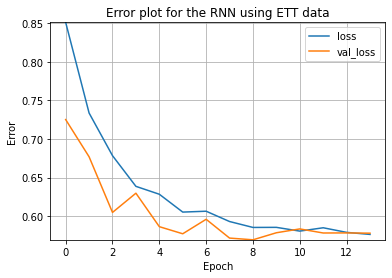

In [87]:
fig=ett_plotlosses[idx]
fig

This method is computationally cheap but because we have made so many assumptions, the accuracy seems to be lowered significantly and the results are highly unstable, making it difficult to reach any conclusions. The main visible problem seems to be use of only the resized coordiantes of the images and not the images themselves. Sometimes, coordinates were also partially discounted. To see a clearer representation of this problem, refer back to the image we plotted where coordinates were partially blocked or distorted by the image's resized dimensions then used to predict the outcomes. 

In [63]:
model.summary()

Model: "sequential_181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_181 (LSTM)              (None, 64)                17152     
_________________________________________________________________
dense_543 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_181 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_544 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_545 (Dense)            (None, 3)                 195       
Total params: 33,923
Trainable params: 33,923
Non-trainable params: 0
_________________________________________________________________
